### Imports


In [ ]:
import os
import math
import time
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

# fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Custom Implementation of Batch Normalization

In [ ]:
class CustomBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum

        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=(0, 2, 3))
            var = x.var(dim=(0, 2, 3), unbiased=False)

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean[None, :, None, None]) / torch.sqrt(var[None, :, None, None] + self.eps)
        out = self.gamma[None, :, None, None] * x_hat + self.beta[None, :, None, None]
        return out


### Defining Inception Block (as proposed in research paper)

In [ ]:
class ConvBNAct(nn.Module):
    def __init__(self, in_c, out_c, k, s=1, p=0, use_bn=False, activation_fn=nn.ReLU):
        super().__init__()
        layers = [nn.Conv2d(in_c, out_c, k, s, p, bias=not use_bn)]
        if use_bn:
            layers.append(CustomBatchNorm2d(out_c))
        layers.append(activation_fn())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class InceptionBlock(nn.Module):
    def __init__(self, in_c, use_bn=False, activation_fn=nn.ReLU):
        super().__init__()

        # shrink all widths
        self.b1 = ConvBNAct(in_c, 8, 1, use_bn=use_bn, activation_fn=activation_fn)

        self.b2 = nn.Sequential(
            ConvBNAct(in_c, 8, 1, use_bn=use_bn, activation_fn=activation_fn),
            ConvBNAct(8, 16, 3, p=1, use_bn=use_bn, activation_fn=activation_fn)
        )

        self.b3 = nn.Sequential(
            ConvBNAct(in_c, 8, 1, use_bn=use_bn, activation_fn=activation_fn),
            ConvBNAct(8, 16, 3, p=1, use_bn=use_bn, activation_fn=activation_fn),
            ConvBNAct(16, 16, 3, p=1, use_bn=use_bn, activation_fn=activation_fn)
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBNAct(in_c, 8, 1, use_bn=use_bn, activation_fn=activation_fn)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)

### TinyInception (Model defination for training)

In [ ]:
class TinyInception(nn.Module):
    def __init__(self, num_classes=10, use_bn=False, activation_fn=nn.ReLU):
        super().__init__()

        self.stem = ConvBNAct(3, 16, 3, p=1, use_bn=use_bn, activation_fn=activation_fn)
        self.inc1 = InceptionBlock(16, use_bn=use_bn, activation_fn=activation_fn)
        self.inc2 = InceptionBlock(48, use_bn=use_bn, activation_fn=activation_fn)
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Use dropout only when BN is OFF
        self.drop = nn.Dropout(0.4) if not use_bn else nn.Identity()

        self.fc = nn.Linear(48, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Loading Dataset

In [ ]:
def load_cifar_10():
    # normalize input for lesser memory consumption
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                            shuffle=False, num_workers=4)

    return trainloader, testloader

### Model Training function


In [ ]:
def train_model(model, trainloader, valloader, epochs=100, lr=0.015,
                resume=True):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    weight_decay_val = 0.0
    if lr == 0.045:
        weight_decay_val = 1e-4 / 5      # 5× less L2 regularization

    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_val)
    criterion = nn.CrossEntropyLoss()

    train_acc_list = []
    val_acc_list = []
    epos = []

    for epoch in range(epochs):
        model.train()
        correct = total = 0

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = criterion(out, y)

            loss.backward()
            opt.step()

            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_acc_list.append(train_acc)
        epos.append(epoch)

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in valloader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                _, pred = out.max(1)
                correct += pred.eq(y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f} | Val Acc={val_acc:.2f}")


    return train_acc_list, val_acc_list, epos

## Training

In [ ]:
trainloader, valloader = load_cifar_10()

100%|██████████| 170M/170M [00:04<00:00, 36.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Experiment 1 - Without Batch Normalization
This will use dropout as proposed in paper to prevent overfitting and giving a regularization effect which is not needed with BN due to it's impact of dealing with the problem of internal covarite shift

In [ ]:
training_results = []

In [ ]:
model_without_bn = TinyInception(use_bn=False)

acc_without_bn_train, acc_without_bn_val, ep = train_model(model_without_bn, trainloader, valloader,epochs=100,lr=0.0015)

Epoch 1: Train Acc=0.11 | Val Acc=0.14
Epoch 2: Train Acc=0.13 | Val Acc=0.15
Epoch 3: Train Acc=0.15 | Val Acc=0.15
Epoch 4: Train Acc=0.16 | Val Acc=0.17
Epoch 5: Train Acc=0.18 | Val Acc=0.20
Epoch 6: Train Acc=0.20 | Val Acc=0.20
Epoch 7: Train Acc=0.21 | Val Acc=0.22
Epoch 8: Train Acc=0.23 | Val Acc=0.24
Epoch 9: Train Acc=0.26 | Val Acc=0.27
Epoch 10: Train Acc=0.27 | Val Acc=0.29
Epoch 11: Train Acc=0.29 | Val Acc=0.30
Epoch 12: Train Acc=0.29 | Val Acc=0.31
Epoch 13: Train Acc=0.30 | Val Acc=0.31
Epoch 14: Train Acc=0.31 | Val Acc=0.32
Epoch 15: Train Acc=0.32 | Val Acc=0.32
Epoch 16: Train Acc=0.33 | Val Acc=0.33
Epoch 17: Train Acc=0.33 | Val Acc=0.34
Epoch 18: Train Acc=0.34 | Val Acc=0.34
Epoch 19: Train Acc=0.34 | Val Acc=0.34
Epoch 20: Train Acc=0.34 | Val Acc=0.35
Epoch 21: Train Acc=0.35 | Val Acc=0.36
Epoch 22: Train Acc=0.35 | Val Acc=0.35
Epoch 23: Train Acc=0.36 | Val Acc=0.36
Epoch 24: Train Acc=0.37 | Val Acc=0.37
Epoch 25: Train Acc=0.37 | Val Acc=0.37
Epoch 26:

In [ ]:
torch.save(model_without_bn.state_dict(), 'model_without_bn.pth')
print("Model 'model_without_bn.pth' saved successfully.")

Model 'model_without_bn.pth' saved successfully.


In [ ]:
training_results.append({
    "model": model_without_bn,
    "train_acc": acc_without_bn_train,
    "val_acc": acc_without_bn_val,
    "epochs": ep,
    "description":"Model Without batch normalization, with 0.4 Dropout"
})
print(f"Training result information appended: {training_results}")

Training result information appended: [{'model': TinyInception(
  (stem): ConvBNAct(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (inc1): InceptionBlock(
    (b1): ConvBNAct(
      (net): Sequential(
        (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (b2): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (1): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
      )
    )
    (b3): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (1): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3

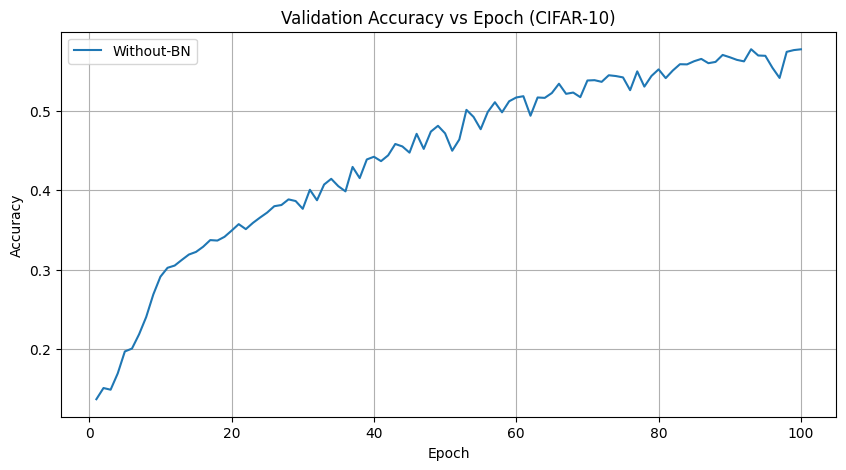

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in ep], acc_without_bn_val, label="Without-BN")
plt.title("Validation Accuracy vs Epoch (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("without-bn.png")
plt.show()


### Experiment 2 - With Batch Normalization



In [ ]:
model_bn = TinyInception(use_bn=True)

acc_with_bn_train, acc_with_bn_val, ep = train_model(model_bn, trainloader, valloader,epochs=30,lr=0.0015)

Epoch 1: Train Acc=0.27 | Val Acc=0.35
Epoch 2: Train Acc=0.37 | Val Acc=0.37
Epoch 3: Train Acc=0.41 | Val Acc=0.42
Epoch 4: Train Acc=0.45 | Val Acc=0.47
Epoch 5: Train Acc=0.48 | Val Acc=0.49
Epoch 6: Train Acc=0.50 | Val Acc=0.51
Epoch 7: Train Acc=0.52 | Val Acc=0.53
Epoch 8: Train Acc=0.54 | Val Acc=0.52
Epoch 9: Train Acc=0.55 | Val Acc=0.54
Epoch 10: Train Acc=0.57 | Val Acc=0.55
Epoch 11: Train Acc=0.58 | Val Acc=0.58
Epoch 12: Train Acc=0.59 | Val Acc=0.56
Epoch 13: Train Acc=0.60 | Val Acc=0.59
Epoch 14: Train Acc=0.61 | Val Acc=0.60
Epoch 15: Train Acc=0.62 | Val Acc=0.62
Epoch 16: Train Acc=0.63 | Val Acc=0.62
Epoch 17: Train Acc=0.63 | Val Acc=0.61
Epoch 18: Train Acc=0.64 | Val Acc=0.65
Epoch 19: Train Acc=0.65 | Val Acc=0.59
Epoch 20: Train Acc=0.65 | Val Acc=0.62
Epoch 21: Train Acc=0.66 | Val Acc=0.62
Epoch 22: Train Acc=0.66 | Val Acc=0.65
Epoch 23: Train Acc=0.66 | Val Acc=0.63
Epoch 24: Train Acc=0.67 | Val Acc=0.65
Epoch 25: Train Acc=0.67 | Val Acc=0.64
Epoch 26:

In [ ]:
torch.save(model_bn.state_dict(), 'model_bn.pth')
print("Model 'model_bn.pth' saved successfully.")

Model 'model_bn.pth' saved successfully.


In [ ]:
training_results.append({
    "model": model_bn,
    "train_acc": acc_with_bn_train,
    "val_acc": acc_with_bn_val,
    "epochs": ep,
    "description":"Model With batch normalization, no dropout"
})
print(f"Training result information appended: {training_results}")

Training result information appended: [{'model': TinyInception(
  (stem): ConvBNAct(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (inc1): InceptionBlock(
    (b1): ConvBNAct(
      (net): Sequential(
        (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (b2): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (1): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
      )
    )
    (b3): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (1): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3

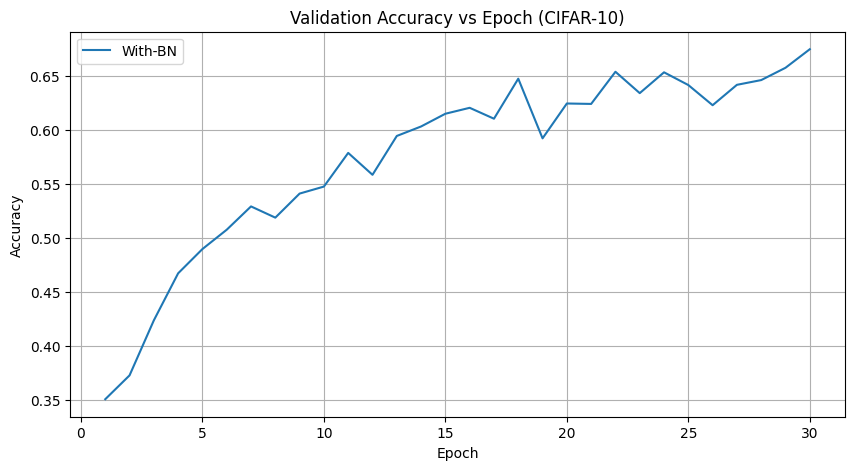

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in ep], acc_with_bn_val, label="With-BN")
plt.title("Validation Accuracy vs Epoch (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("with-bn.png")
plt.show()

### Experiment 3 - With Batch Normalization (5 times learning rate)

As proposed in the paper, with higher learning rate in BN, we don't face any issues and can achieve similar results faster

In [ ]:
model_bn_x5 = TinyInception(use_bn=True)

acc_with_bn_x5_train, acc_with_bn_x5_val, ep = train_model(model_bn_x5, trainloader, valloader,epochs=30,lr=0.0075)

Epoch 1: Train Acc=0.37 | Val Acc=0.43
Epoch 2: Train Acc=0.50 | Val Acc=0.40
Epoch 3: Train Acc=0.55 | Val Acc=0.56
Epoch 4: Train Acc=0.58 | Val Acc=0.55
Epoch 5: Train Acc=0.61 | Val Acc=0.61
Epoch 6: Train Acc=0.63 | Val Acc=0.57
Epoch 7: Train Acc=0.64 | Val Acc=0.59
Epoch 8: Train Acc=0.65 | Val Acc=0.61
Epoch 9: Train Acc=0.66 | Val Acc=0.60
Epoch 10: Train Acc=0.67 | Val Acc=0.64
Epoch 11: Train Acc=0.68 | Val Acc=0.64
Epoch 12: Train Acc=0.68 | Val Acc=0.63
Epoch 13: Train Acc=0.69 | Val Acc=0.65
Epoch 14: Train Acc=0.69 | Val Acc=0.67
Epoch 15: Train Acc=0.70 | Val Acc=0.67
Epoch 16: Train Acc=0.70 | Val Acc=0.65
Epoch 17: Train Acc=0.71 | Val Acc=0.68
Epoch 18: Train Acc=0.71 | Val Acc=0.68
Epoch 19: Train Acc=0.71 | Val Acc=0.66
Epoch 20: Train Acc=0.72 | Val Acc=0.67
Epoch 21: Train Acc=0.72 | Val Acc=0.67
Epoch 22: Train Acc=0.72 | Val Acc=0.68


In [ ]:
torch.save(model_bn_x5.state_dict(), 'model_bn_x5.pth')
print("Model 'model_bn_x5.pth' saved successfully.")

In [ ]:
training_results.append({
    "model": model_bn_x5,
    "train_acc": acc_with_bn_x5_train,
    "val_acc": acc_with_bn_x5_val,
    "epochs": ep,
    "description":"Model With batch normalization, no dropout, learning rate x5 (0.0075)"
})
print(f"Training result information appended: {training_results}")

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in ep], acc_with_bn_x5_val, label="With-BN-x5")
plt.title("Validation Accuracy vs Epoch (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("with-bn-x5.png")
plt.show()

### Experiment 4 - With Batch Normalization (30 times learning rate)

As proposed in paper we tried to implement model with 30 times the learning rate. Also added regularization so that model doesn't overfit for such a high learning rate

In [ ]:
model_bn_x30 = TinyInception(use_bn=True)

acc_with_bn_x30_train, acc_with_bn_x30_val, ep = train_model(model_bn_x30, trainloader, valloader,epochs=30,lr=0.045)

Epoch 1: Train Acc=0.41 | Val Acc=0.42
Epoch 2: Train Acc=0.54 | Val Acc=0.54
Epoch 3: Train Acc=0.59 | Val Acc=0.57
Epoch 4: Train Acc=0.62 | Val Acc=0.63
Epoch 5: Train Acc=0.64 | Val Acc=0.62
Epoch 6: Train Acc=0.66 | Val Acc=0.60
Epoch 7: Train Acc=0.67 | Val Acc=0.62
Epoch 8: Train Acc=0.67 | Val Acc=0.59
Epoch 9: Train Acc=0.68 | Val Acc=0.58
Epoch 10: Train Acc=0.69 | Val Acc=0.67
Epoch 11: Train Acc=0.69 | Val Acc=0.66
Epoch 12: Train Acc=0.70 | Val Acc=0.69
Epoch 13: Train Acc=0.71 | Val Acc=0.68
Epoch 14: Train Acc=0.71 | Val Acc=0.59
Epoch 15: Train Acc=0.71 | Val Acc=0.65
Epoch 16: Train Acc=0.72 | Val Acc=0.67
Epoch 17: Train Acc=0.72 | Val Acc=0.65
Epoch 18: Train Acc=0.73 | Val Acc=0.65
Epoch 19: Train Acc=0.73 | Val Acc=0.67
Epoch 20: Train Acc=0.73 | Val Acc=0.67
Epoch 21: Train Acc=0.74 | Val Acc=0.68
Epoch 22: Train Acc=0.73 | Val Acc=0.62
Epoch 23: Train Acc=0.74 | Val Acc=0.72
Epoch 24: Train Acc=0.74 | Val Acc=0.64
Epoch 25: Train Acc=0.74 | Val Acc=0.70
Epoch 26:

In [ ]:
torch.save(model_bn_x30.state_dict(), 'model_bn_x30.pth')
print("Model 'model_bn_x30.pth' saved successfully.")

Model 'model_bn_x30.pth' saved successfully.


In [ ]:
training_results.append({
    "model": model_bn_x30,
    "train_acc": acc_with_bn_x30_train,
    "val_acc": acc_with_bn_x30_val,
    "epochs": ep,
    "description":"Model With batch normalization, no dropout, learning rate x30 (0.045)"
})
print(f"Training result information appended: {training_results}")

Training result information appended: [{'model': TinyInception(
  (stem): ConvBNAct(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): CustomBatchNorm2d()
      (2): ReLU()
    )
  )
  (inc1): InceptionBlock(
    (b1): ConvBNAct(
      (net): Sequential(
        (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): CustomBatchNorm2d()
        (2): ReLU()
      )
    )
    (b2): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): CustomBatchNorm2d()
          (2): ReLU()
        )
      )
      (1): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): CustomBatchNorm2d()
          (2): ReLU()
        )
      )
    )
    (b3): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Co

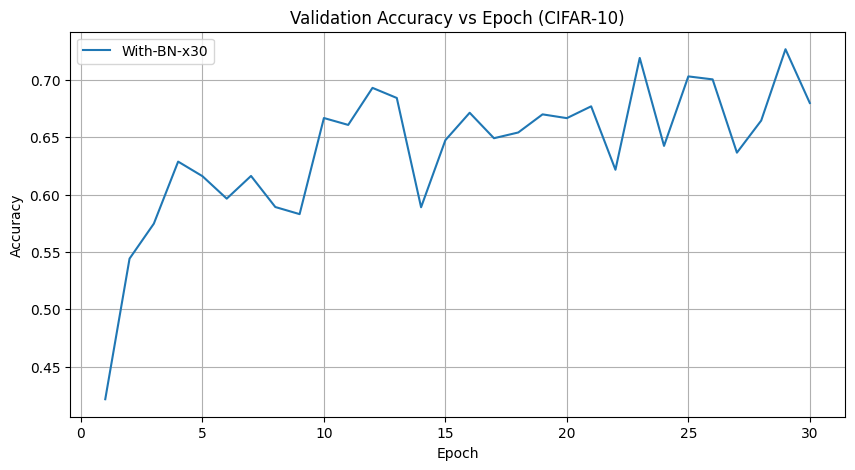

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in ep], acc_with_bn_x30_val, label="With-BN-x30")
plt.title("Validation Accuracy vs Epoch (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("with-bn-x30.png")
plt.show()

### Experiment 5 - With Batch Normalization and Sigmoid as non-linearity

In [ ]:
model_bn_x5_sigmoid = TinyInception(use_bn=True, activation_fn=nn.Sigmoid)

acc_with_bn_x5_sigmoid_train, acc_with_bn_x5_sigmoid_val, ep = train_model(model_bn_x5_sigmoid, trainloader, valloader,epochs=30,lr=0.0075)

Epoch 1: Train Acc=0.24 | Val Acc=0.31
Epoch 2: Train Acc=0.32 | Val Acc=0.32
Epoch 3: Train Acc=0.34 | Val Acc=0.36
Epoch 4: Train Acc=0.37 | Val Acc=0.30
Epoch 5: Train Acc=0.40 | Val Acc=0.33
Epoch 6: Train Acc=0.43 | Val Acc=0.30
Epoch 7: Train Acc=0.44 | Val Acc=0.36
Epoch 8: Train Acc=0.46 | Val Acc=0.46
Epoch 9: Train Acc=0.47 | Val Acc=0.38
Epoch 10: Train Acc=0.48 | Val Acc=0.43
Epoch 11: Train Acc=0.49 | Val Acc=0.41
Epoch 12: Train Acc=0.51 | Val Acc=0.37
Epoch 13: Train Acc=0.51 | Val Acc=0.48
Epoch 14: Train Acc=0.52 | Val Acc=0.49
Epoch 15: Train Acc=0.53 | Val Acc=0.36
Epoch 16: Train Acc=0.54 | Val Acc=0.50
Epoch 17: Train Acc=0.55 | Val Acc=0.49
Epoch 18: Train Acc=0.55 | Val Acc=0.42
Epoch 19: Train Acc=0.56 | Val Acc=0.30
Epoch 20: Train Acc=0.56 | Val Acc=0.52
Epoch 21: Train Acc=0.57 | Val Acc=0.44
Epoch 22: Train Acc=0.57 | Val Acc=0.53
Epoch 23: Train Acc=0.58 | Val Acc=0.55
Epoch 24: Train Acc=0.58 | Val Acc=0.53
Epoch 25: Train Acc=0.59 | Val Acc=0.41
Epoch 26:

In [ ]:
torch.save(model_bn_x5_sigmoid.state_dict(), 'model_bn_x5_sigmoid.pth')
print("Model 'model_bn_x5_sigmoid.pth' saved successfully.")

Model 'model_bn_x5_sigmoid.pth' saved successfully.


In [ ]:
training_results.append({
    "model": model_bn_x5_sigmoid,
    "train_acc": acc_with_bn_x5_sigmoid_train,
    "val_acc": acc_with_bn_x5_sigmoid_val,
    "epochs": ep,
    "description":"Model With batch normalization, no dropout, learning rate x5 (0.0075), Sigmoid as non-linearity"
})
print(f"Training result information appended: {training_results}")

Training result information appended: [{'model': TinyInception(
  (stem): ConvBNAct(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): CustomBatchNorm2d()
      (2): Sigmoid()
    )
  )
  (inc1): InceptionBlock(
    (b1): ConvBNAct(
      (net): Sequential(
        (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): CustomBatchNorm2d()
        (2): Sigmoid()
      )
    )
    (b2): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): CustomBatchNorm2d()
          (2): Sigmoid()
        )
      )
      (1): ConvBNAct(
        (net): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): CustomBatchNorm2d()
          (2): Sigmoid()
        )
      )
    )
    (b3): Sequential(
      (0): ConvBNAct(
        (net): Sequential(
     

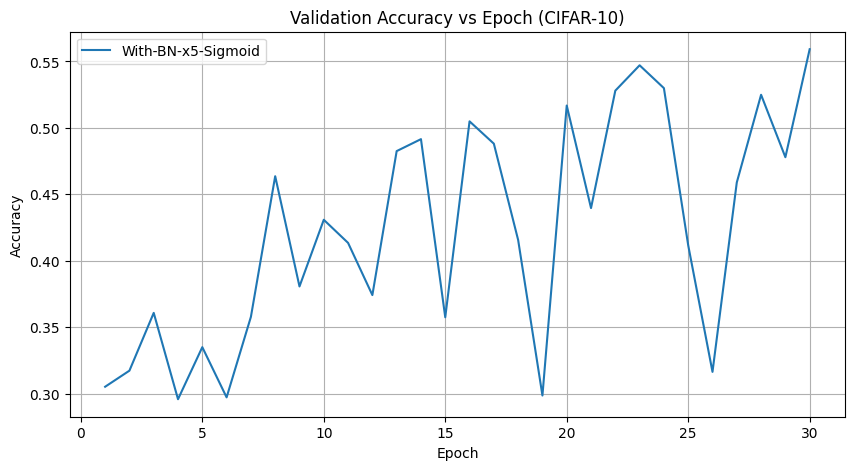

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in ep], acc_with_bn_x5_sigmoid_val, label="With-BN-x5-Sigmoid")
plt.title("Validation Accuracy vs Epoch (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("with-bn-x5-sigmoid.png")
plt.show()

### Saving results

In [ ]:
import json

# Prepare the training results for JSON serialization by excluding model objects
serializable_results = []
for result in training_results:
    serializable_result = {
        "train_acc": result["train_acc"],
        "val_acc": result["val_acc"],
        "epochs": result["epochs"],
        "description": result["description"]
    }
    serializable_results.append(serializable_result)

# Save the serializable results to a JSON file
with open('training_results.json', 'w') as f:
    json.dump(serializable_results, f, indent=4)

print("Training results saved to 'training_results.json' successfully.")